We are often asked how to organise a code for tasks such as:
* performing the same analysis on different models or grid resolutions
* performing an analysis on one dataset for different options (e.g. different seasons)

The principle to apply in all cases is to avoid repeating code. In Python and most of other programming languages, to avoid repetition one can use dictionaries and/or functions and/or classes.

In this blog, we are going to use a small example to illustrate those techniques. Those techniques can often be used interchangeably. Usually, functions and classes result in more flexible and reusable code.

Note: the analysis chosen here does not need to use dictionaries and functions to be done. We only do so here to illustrate the generic process. The direct way to perform the analysis is noted at the end of this notebook.

In [1]:
import xarray as xr
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

# Badly organised code
The following code is correct as it gives the correct answer but it is prone to errors because the code is repeated. This increases the risk of typos. For more complex analyses, it can also make it harder to test as it is not modular.

<xarray.DataArray 'tsl' (time: 1980, lat: 96, lon: 96)>
dask.array<getitem, shape=(1980, 96, 96), dtype=float32, chunksize=(1980, 96, 96), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float32 -90.0 -88.11 -86.21 -84.32 ... 84.32 86.21 88.11 90.0
  * lon      (lon) float32 360.0 3.75 7.5 11.25 15.0 ... 345.0 348.8 352.5 356.2
    solth    float32 0.01419
  * time     (time) object 1850-01-16 12:00:00 ... 2014-12-16 12:00:00
Attributes:
    long_name:           Temperature of Soil
    units:               K
    online_operation:    average
    cell_methods:        area: mean where land time: mean
    interval_operation:  1800 s
    interval_write:      1 month
    standard_name:       soil_temperature
    description:         Temperature of each soil layer.  Reported as "missin...
    history:             none
    cell_measures:       area: areacella

<xarray.DataArray 'tsl' (time: 1980, lat: 96, lon: 96)>
dask.array<getitem, shape=(1980, 96, 96), dtype=float32, chunksize=(1980, 96, 96), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float32 -90.0 -88.11 -86.21 -84.32 ... 84.32 86.21 88.11 90.0
  * lon      (lon) float32 360.0 3.75 7.5 11.25 15.0 ... 345.0 348.8 352.5 356.2
    solth    float32 0.01419
  * time     (time) object 1850-01-16 12:00:00 ... 2014-12-16 12:00:00
Attributes:
    long_name:           Temperature of Soil
    units:               K
    online_operation:    average
    cell_methods:        area: mean where land time: mean
    interval_operation:  1800 s
    interval_write:      1 month
    standard_name:       soil_temperature
    description:         Temperature of each soil layer.  Reported as "missin...
    history:             none
    cell_measures:       area: areacella

/g/data/hh5/public/apps/miniconda3/envs/analysis3-21.07/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1395: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,


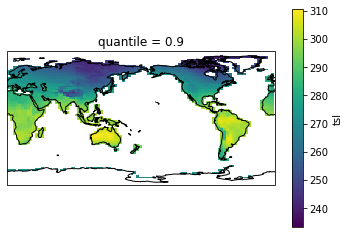

In [2]:
# Read in the data we need

## Paths to 2 CMIP6 model experiments
IPSL_path = Path("/g/data/oi10/replicas/CMIP6/CMIP/IPSL/IPSL-CM5A2-INCA/")
historical_path = IPSL_path/"historical/r1i1p1f1/Lmon/tsl/gr/v20200729/"
picontrol_path  = IPSL_path/"piControl/r1i1p1f1/Lmon/tsl/gr/v20210216/"
## Find all netcdf files in those directories. 
historical_path = sorted(historical_path.glob("*.nc"))
picontrol_path  = sorted(picontrol_path.glob("*.nc"))

historical_ds = xr.open_mfdataset(historical_path)
picontrol_ds  = xr.open_mfdataset(picontrol_path)

# Select the data to cover the same space and period for both datasets
## Select the surface only
historical_tsl = historical_ds["tsl"].isel(solth=0)
picontrol_tsl  = picontrol_ds["tsl"].isel(solth=0)

## Restrict the data to the longest common time window.
picontrol_tsl = picontrol_tsl.sel(time=historical_tsl.time)

# Check our data
## Use display() to get a nice display of the DataArray instead of print()
display(historical_tsl)
display(picontrol_tsl)

# Do our analysis: calculate a percentile for each season
time = historical_tsl.time
hist_pct_djf = historical_tsl.where(time.dt.season == 'DJF').quantile(0.9, dim=["time"])
hist_pct_mam = historical_tsl.where(time.dt.season == 'MAM').quantile(0.9, dim=["time"])
hist_pct_jja = historical_tsl.where(time.dt.season == 'JJA').quantile(0.9, dim=["time"])
hist_pct_son = historical_tsl.where(time.dt.season == 'SON').quantile(0.9, dim=["time"])
pic_pct_djf  = picontrol_tsl.where(time.dt.season == 'DJF').quantile(0.9, dim=["time"])
pic_pct_mam  = picontrol_tsl.where(time.dt.season == 'MAM').quantile(0.9, dim=["time"])
pic_pct_jja  = picontrol_tsl.where(time.dt.season == 'JJA').quantile(0.9, dim=["time"])
pic_pct_son  = picontrol_tsl.where(time.dt.season == 'SON').quantile(0.9, dim=["time"])

# Check out results with a plot. We remove the first longitude because it's not in sorted order otherwise.
fg=hist_pct_djf.isel(lon=slice(1,None)).plot(transform=ccrs.PlateCarree(),
    subplot_kws={
        "projection": ccrs.PlateCarree(central_longitude=180.)
    }
)
fg.axes.coastlines()

## Analysis
The code has three parts:
* read in the data
* select the data
* perform the analysis
There are also some checks done either with displaying the data or plotting the data.

The code has a lot of similar lines with only an option that changes between the lines. It was quite long to write as each time I had to be careful to use the correct name. 

### Reading the data
The part to read the data is essentially composed of 2 sets of copied lines, changing only the inputs: once for the historical data path and once for the pi-Control data path.

### Select the data
This part is very short. Although the part to select only the surface layer (`isel(solth=0)`) is repeated, it is only one line so it's fine to keep.

### Perform the analysis
In this case, we have 2 sets of four lines. For each dataset, we have a different line for each season. In short, we are performing the same analysis on 2 datasets for 4 options each time. We could simplify that with a function that would calculate the analysis for all 4 options at once.

Now let's see how we can rewrite the code in a more modular way and limiting copied lines

# Better code structure
## Reading and select the data


In [3]:
# Define a function to read in the data
def get_var(path, varname):
    """Reads in all the netcdf files in the input path and return the data for the selected variable
    path: pathlib.Path, path to the netcdf files
    varname: string, name of the variable to select in the netcdf files"""
    
    netcdf_files = sorted(path.glob("*.nc"))
    ds = xr.open_mfdataset(netcdf_files)
    
    return ds[varname]

In [4]:
# Paths to 2 CMIP6 model experiments
IPSL_path = Path("/g/data/oi10/replicas/CMIP6/CMIP/IPSL/IPSL-CM5A2-INCA/")

variable = 'tsl'

experiments = {
    "historical": IPSL_path / "historical/r1i1p1f1/Lmon" / variable / "gr/v20200729/",
    "picontrol": IPSL_path / "piControl/r1i1p1f1/Lmon" / variable / "gr/v20210216/",
}

# Dictionary to store the experiments with the experiment name as their key and data
# as the value
data = {}
for expt, path in experiments.items():
    # Find all netcdf files in those directories and restric the data to the surface layer.
    data[expt] = get_var(path, variable).isel(solth=0)

# Restrict the data to the longest common time window.
data["picontrol"] = data["picontrol"].sel(time=data["historical"].time)

for expt in data.keys():
    display(data[expt])

<xarray.DataArray 'tsl' (time: 1980, lat: 96, lon: 96)>
dask.array<getitem, shape=(1980, 96, 96), dtype=float32, chunksize=(1980, 96, 96), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float32 -90.0 -88.11 -86.21 -84.32 ... 84.32 86.21 88.11 90.0
  * lon      (lon) float32 360.0 3.75 7.5 11.25 15.0 ... 345.0 348.8 352.5 356.2
    solth    float32 0.01419
  * time     (time) object 1850-01-16 12:00:00 ... 2014-12-16 12:00:00
Attributes:
    long_name:           Temperature of Soil
    units:               K
    online_operation:    average
    cell_methods:        area: mean where land time: mean
    interval_operation:  1800 s
    interval_write:      1 month
    standard_name:       soil_temperature
    description:         Temperature of each soil layer.  Reported as "missin...
    history:             none
    cell_measures:       area: areacella

<xarray.DataArray 'tsl' (time: 1980, lat: 96, lon: 96)>
dask.array<getitem, shape=(1980, 96, 96), dtype=float32, chunksize=(1980, 96, 96), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float32 -90.0 -88.11 -86.21 -84.32 ... 84.32 86.21 88.11 90.0
  * lon      (lon) float32 360.0 3.75 7.5 11.25 15.0 ... 345.0 348.8 352.5 356.2
    solth    float32 0.01419
  * time     (time) object 1850-01-16 12:00:00 ... 2014-12-16 12:00:00
Attributes:
    long_name:           Temperature of Soil
    units:               K
    online_operation:    average
    cell_methods:        area: mean where land time: mean
    interval_operation:  1800 s
    interval_write:      1 month
    standard_name:       soil_temperature
    description:         Temperature of each soil layer.  Reported as "missin...
    history:             none
    cell_measures:       area: areacella

First, we define a function to read in the data to reduce the number of lines copied.
We also define two dictionaries:
* A user-defined dictionary, `experiments`, that stores the name of the experiments and the paths to the data.
* A computed dictionary, `data`, that associates the data to each corresponding experiment

This structures allows us to expand to more experiments more easily. One just needs to add an experiment name and path to the `experiments` dictionary. Everything else is then computed for all datasets via a loop through the keys of the `experiments` or `data` dictionaries.

## Analysis
For our analysis, we will define dictionaries and functions again. This will reduce the number of copied lines from 8 to 0.

In this way, we also remove any hard-written reference to the name of the experiments and it will work for any number of experiments. The final dictionary `pct_dict` contains a dictionary associated with each key, i.e. a dictionary of dictionaries. The keys of `pct_dict` are the names of the experiments originally defined in `experiments`

In [5]:
# Do our analysis: calculate a percentile for each season
def season_quantile(data, quantile):
    """Calculate a quantile for each season in the input data
    
    data: DataArray, data with a dimension named 'time'
    quantile: scalar, quantile to calculate for the data"""
    
    seas_pct = {}
    for season, seas_data in data.groupby('time.season'):
        seas_pct[season] = seas_data.quantile(0.9, dim="time")

    return seas_pct

pct_dict_dict={}
for expt in data.keys():
    pct_dict_dict[expt] = season_quantile(data[expt], 0.9)

print(pct_dict_dict["historical"])

{'DJF': <xarray.DataArray 'tsl' (lat: 96, lon: 96)>
dask.array<getitem, shape=(96, 96), dtype=float64, chunksize=(96, 96), chunktype=numpy.ndarray>
Coordinates:
  * lat       (lat) float32 -90.0 -88.11 -86.21 -84.32 ... 86.21 88.11 90.0
  * lon       (lon) float32 360.0 3.75 7.5 11.25 ... 345.0 348.8 352.5 356.2
    quantile  float64 0.9, 'JJA': <xarray.DataArray 'tsl' (lat: 96, lon: 96)>
dask.array<getitem, shape=(96, 96), dtype=float64, chunksize=(96, 96), chunktype=numpy.ndarray>
Coordinates:
  * lat       (lat) float32 -90.0 -88.11 -86.21 -84.32 ... 86.21 88.11 90.0
  * lon       (lon) float32 360.0 3.75 7.5 11.25 ... 345.0 348.8 352.5 356.2
    quantile  float64 0.9, 'MAM': <xarray.DataArray 'tsl' (lat: 96, lon: 96)>
dask.array<getitem, shape=(96, 96), dtype=float64, chunksize=(96, 96), chunktype=numpy.ndarray>
Coordinates:
  * lat       (lat) float32 -90.0 -88.11 -86.21 -84.32 ... 86.21 88.11 90.0
  * lon       (lon) float32 360.0 3.75 7.5 11.25 ... 345.0 348.8 352.5 356.2
    qu

## Plot the data
The easiest way to perform a panel plot of all the percentiles is to get the data in a DataArray instead of a dictionary. 

For this, we give two solutions:
* a function to concatenate a dictionary with DataArrays as values into a single DataArray. We concatenate along a new dimension and the keys of the dicionary are the names of the seasons.
* a different implementation of `season_quantile` to output a DataArray instead of a dictionary

In [6]:
def dictionary_to_dataarray(input_dic, new_dim_name):
    """Concatenate the data from a dictionary to a DataArray along a new dimension.
    The keys of the dictionary are used to create a coordinate for this new dimension"""
    
    # Concatenate all the data in one DataArray along a new dimension
    da = xr.concat([data for data in input_dic.values()], dim=new_dim_name)

    # Add the dictionary keys to create a coordinate for the new dimension. 
    # Not necessary but nice to have.
    da = da.assign_coords({new_dim_name:list(input_dic.keys())})
    
    return da
    
pct_dict = {}
for expt in data.keys():
    pct_dict[expt] = dictionary_to_dataarray(pct_dict_dict[expt], "season")

print(pct_dict["historical"])

<xarray.DataArray 'tsl' (season: 4, lat: 96, lon: 96)>
dask.array<concatenate, shape=(4, 96, 96), dtype=float64, chunksize=(1, 96, 96), chunktype=numpy.ndarray>
Coordinates:
  * lat       (lat) float32 -90.0 -88.11 -86.21 -84.32 ... 86.21 88.11 90.0
  * lon       (lon) float32 360.0 3.75 7.5 11.25 ... 345.0 348.8 352.5 356.2
    quantile  float64 0.9
  * season    (season) <U3 'DJF' 'JJA' 'MAM' 'SON'


In [7]:
# Modify season_quantile to output a DataArray
def season_quantile_DA(data, quantile):
    """Calculate a quantile for each season in the input data
    
    data: DataArray, data with a dimension named 'time'
    quantile: scalar, quantile to calculate for the data"""
    
    seas_pct = []
    seas_coords = []
    for season, seas_data in data.groupby('time.season'):
        seas_coords.append(season)
        seas_pct.append(seas_data.quantile(0.9, dim="time"))

    # Concatenate list to DataArray along a `season` dimension and 
    # add coordinate for this new dimension
    da = xr.concat(seas_pct,dim="season")
    da = da.assign_coords({"season":seas_coords})

    return da

pct_dict={}
for expt in data.keys():
    pct_dict[expt] = season_quantile_DA(data[expt], 0.9)

print(pct_dict["historical"])


<xarray.DataArray 'tsl' (season: 4, lat: 96, lon: 96)>
dask.array<concatenate, shape=(4, 96, 96), dtype=float64, chunksize=(1, 96, 96), chunktype=numpy.ndarray>
Coordinates:
  * lat       (lat) float32 -90.0 -88.11 -86.21 -84.32 ... 86.21 88.11 90.0
  * lon       (lon) float32 360.0 3.75 7.5 11.25 ... 345.0 348.8 352.5 356.2
    quantile  float64 0.9
  * season    (season) <U3 'DJF' 'JJA' 'MAM' 'SON'


We could also simply call `dictionary_to_dataarray` from `season_quantile` to transform the dictionary into a dataarray just before returning the result. All of these ways to do it are quite equivalent. If you know you want a DataArray, you may as well write a function that gives you a DataArray. 

### Plotting

In [8]:
def season_plot(da):
    
    # Plot using the season dimension to create the panel plot
    fg=da.isel(lon=slice(1,None)).plot(col="season", col_wrap=2,
        transform=ccrs.PlateCarree(),
        subplot_kws={
            "projection": ccrs.PlateCarree(central_longitude=180.)
        }
    )
    fg.map(lambda: plt.gca().coastlines())

/g/data/hh5/public/apps/miniconda3/envs/analysis3-21.07/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1395: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,


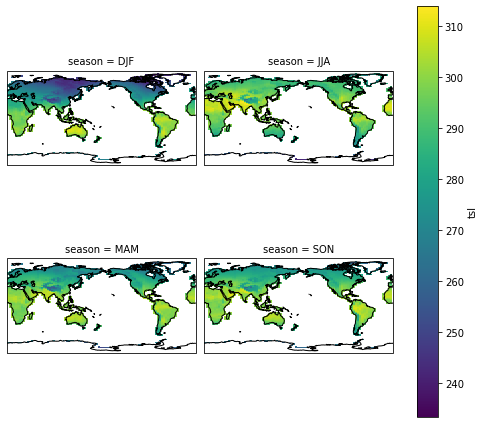

In [9]:
season_plot(pct_dict["historical"])

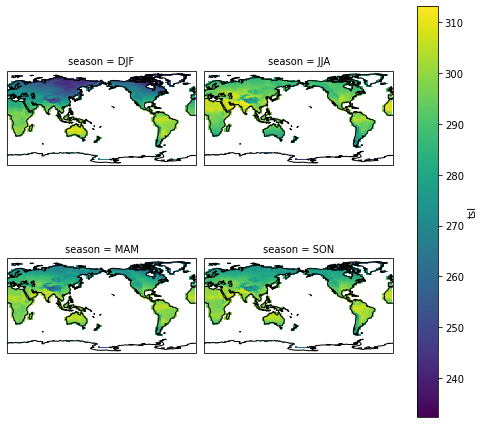

In [10]:
season_plot(pct_dict["picontrol"])

# Conclusion
When you wonder how to organise your code, keep those principles in mind:
* reduce the number of lines that are copied with a single option changed.
* simplify adding an extra case to the analysis. For example, in the final version of the code, we only need to add one line to the `experiments` dictionary to run the analysis on 3 datasets instead of 2.

Dictionaries and functions are often useful to reach those goals. The final version of the code isn't necessarily shorter but it is more flexible and contains functions that could prove useful to re-use in other analyses.

# Disclaimer
For this specific analysis we don't need the dictionary or function. We only do so here to create a simple example for people to understand. Normally, the seasonal quantiles can be calculated with:

`hist_pct = historical["tsl"].groupby('time.season').quantile(0.9, dim="time")`